# Измерение звездного фона и коэффициента его ослабления фильтрами

    Место измерений п.Научный КрАО.
    Измерения проводились в период 21:42 по 23:08 08.11.2018.
    В поле зрения прибора визуально наблюдался Млечный путь.
    Код питающего напряжения - 250. U1=-26.8В, U2=+2.05В (Общее ~28,8В).

    No.|~время |Назначение
    1 21:42 Без фильтров
    2 21:50 УФС-1
    3 21:56 Без фильтров
    4 22:02 УФС-5
    5 22:07 Без фильтров
    6 22:13 ФС6 (BG3)
    7 22:18 Без фильтров
    8 22:25 SL360\50
    9 22:30 Без фильтров
    10 22:35 SL280-380
    11 22:40 Без фильтров
    12 22:46 FF01-375/110
    13 22:56 Без фильтров
    14 23:04 С закрытой диафрагмой (собственный тепловой шум SiPM, пьедестал)


Сбой в записи в файл 08.11.2018   с  20:08:33 по 20:19:05  и  с  21:30:40 по 21:37:32, что не входит во временной интервал измерений.

In [1]:
!date
!pwd
#/home/sphere/ExpData/Program/Sketch/Data

Ср ноя 14 23:18:05 MSK 2018
/home/alena/Arduino/Detector/Data


In [2]:
import pandas as pd
import numpy as np

## Чтение файла данных

In [3]:
## ['date', 'time', 'On', 'u', 'i', 't', 'u5', 'dac', 'CH0', 'CH1', 'CH2', 'CH3', 'U']
dtype = {'date': str, 'time': str, 'On': str, 'u': str, 'i': str, 't': str, 'u5': str, 'dac': str,
         'CH0': np.uint8, 'CH1': np.uint8, 'CH2': np.uint8, 'CH3': np.uint8}

In [4]:
#data = pd.read_csv("data_measurements.txt", index_col=False, sep='\\s+',usecols=dtype.keys(), dtype=dtype)
data = pd.read_csv("data_measurements_1.txt", index_col=False, sep='\\s+')
data = data.drop(columns = "adc")

## reject lines
data = data[~data.On.isin(['OFF'])]
data = data[~data.date.isin(['OK','>','Recv','ADC_on:','DAC_write', 'ADC_off:','SEND','Start'])] #,'Input:'])]
data = data[~data.date.str.contains(r'AT+')]
data = data[~data.date.str.contains(r'SEN')]
data = data[data.date > '07.11.2018']

## add columns
data["U"]  = data.CH0 * 0.01528 - 36.91
data["I"]  = (4094.0 - data.CH1)/10.372
data["U5"] = (data.CH2 + 20.0)*0.01
data["T"]  = (data.CH3/2.0 - 500) * 0.1
#data['timestamp'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'])

## save data file
print(data.shape)
data.to_csv("data_input.csv")

data.drop(columns=['On', 'u', 'i', 't', 'u5', 'dac'], inplace = True)
data.head()
#data.describe()

(3041, 16)


,date,time,CH0,CH1,CH2,CH3,U,I,U5,T
0,Input:,21:c+measurements_begin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Input:,18:c+without+filters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Input:,2:n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,08.11.2018,21:42:10,1439.0,4094.0,474.0,1145.0,-14.92208,0.0,4.94,7.25
73,08.11.2018,21:42:11,1440.0,4094.0,474.0,1145.0,-14.90680,0.0,4.94,7.25


## Таблица результатов

In [5]:
table = pd.read_csv("table1.csv", index_col=False)
print(table.shape)
#table

(18, 6)


In [7]:
table['count'] = [0] * table.shape[0]
for i in range(table.shape[0]):
    part=data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
    #print(i, part.U.count(), part.U.mean(), sep='\t')
    table.loc[i, 'count'] = part.U.count()
    table.loc[i, 'U']     = part.U.mean()
    table.loc[i, 'Ustd'] = part.U.std()
    table.loc[i, 'I']    = part.I.mean()
    table.loc[i, 'Istd'] = part.I.std()
    table.loc[i, 'T']    = part['T'].mean()
    table.loc[i, 'Tstd'] = part['T'].std()
    table.loc[i, 'U5']   = part.U5.mean()
    table.loc[i, 'U5std'] = part.U5.std()
    table.loc[i, 'index0'] = part.index[0]
    table.loc[i, 'index1'] = part.index[part.U.count()-1]
    #print(i, part.index[0], part.index[part.U.count()-1])
    #if i== 3:
        #print(part)

    name      --- комментарий к периоду измерений
    w         --- код DAC высокого напряжения
    begin     --- время начала периода измерений
    end       --- время окончания периода измерений
    count     --- количество измерений (секунд)
    U, Ustd   --- среднее и станд. отклонение напряжения источника  
    I, Istd   --- то же для тока SiPM
    T, Tstd   --- то же для температуры
    U5, U5std --- то же для напряжения 5В

In [8]:
table.drop(columns = ['N', 'time'])

,name,w,begin,end,count,U,Ustd,I,Istd,T,Tstd,U5,U5std,index0,index1
0,Без_фильтров,0,21:42:10,21:42:22,13,-14.905625,0.011606,0.037082,0.062711,7.215385,0.031521,4.941538,0.003755,72.0,84.0
1,Без_фильтров,230,21:42:23,21:42:43,20,-25.164264,0.007184,17.942538,0.168161,7.225000,0.025649,4.941000,0.003078,91.0,110.0
2,Без_фильтров,250,21:42:44,21:45:04,136,-26.767114,0.006394,37.688432,0.200830,7.245588,0.024699,4.940147,0.002103,117.0,252.0
3,УФС-1,250,21:50:29,21:53:54,199,-26.766691,0.005967,12.055554,0.144973,7.441960,0.043353,4.942915,0.004556,326.0,529.0
4,Без_фильтров,250,21:56:27,21:58:45,134,-26.766817,0.005881,38.019265,0.201319,7.443284,0.030529,4.941119,0.003609,689.0,827.0
5,УФС-5,250,22:02:53,22:05:35,157,-26.766221,0.005321,9.686785,0.128502,7.369108,0.050171,4.942739,0.004474,1078.0,1239.0
6,Без_фильтров,250,22:07:40,22:10:53,187,-26.767103,0.006104,37.986888,0.216050,7.264973,0.028215,4.940856,0.003165,1371.0,1561.0
7,ФС6_(BG3),250,22:13:13,22:16:29,190,-26.766573,0.005661,17.035744,0.150788,7.280000,0.040434,4.940526,0.002464,1708.0,1903.0
8,Без_фильтров,250,22:18:45,22:21:14,144,-26.765990,0.005383,38.444852,0.217986,7.174306,0.041386,4.941944,0.003972,2047.0,2193.0
9,SL360\50,250,22:25:08,22:28:23,189,-26.766748,0.005816,1.548736,0.091476,7.894444,0.129989,4.944233,0.004954,2429.0,2622.0


In [9]:
table.to_csv("results.csv")

## Визуализация данных

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

In [11]:
plt.rcParams['figure.figsize'] =(10,6)
plt.rcParams['lines.markersize'] = 5
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [12]:
#plt.plot(table.U5);
print('Напряжение 5В стабильно.')
print('Разброс напряжения: {:.3f} +- {:.3f}'.format( table.U5.mean(), 0.5*(table.U5.max()-table.U5.min()) ) )

Напряжение 5В стабильно.
Разброс напряжения: 4.941 +- 0.002


In [13]:
def draw_parameter(param):
    plt.figure(figsize = (10,6))
    x = table.U[(table.name == 'Без_фильтров') & (table.w > 10)]
    y = table[param][(table.name == 'Без_фильтров') & (table.w > 10)]
    plt.plot(x, y, '*', label = 'Без_фильтров')
    x = table.U[table.name == 'С_закрытой_диафрагмой']
    y = table[param][table.name == 'С_закрытой_диафрагмой']
    plt.plot(x, y, 'o', label = 'С_закрытой_диафрагмой')
    for i in ['УФС-1', 'УФС-5', 'ФС6_(BG3)', 'SL360\50', 'SL280-380','FF01-375/110']:
        x = table.U[table.name == i]
        y = table[param][table.name == i]
        plt.plot(x, y, '>', label= i)
    plt.xlabel( 'U, V')
    plt.ylabel( 'I, uA')
    plt.legend()
    plt.grid()

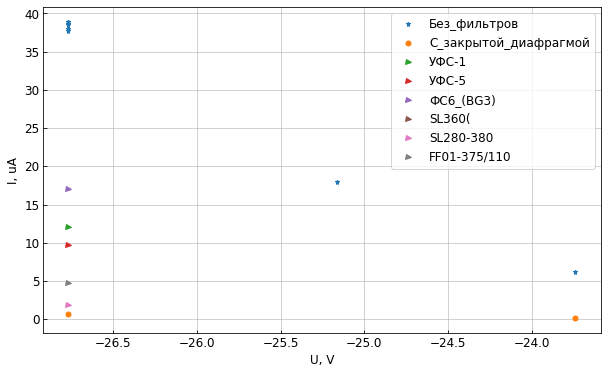

In [14]:
## график токов
draw_parameter('I')

### Температура

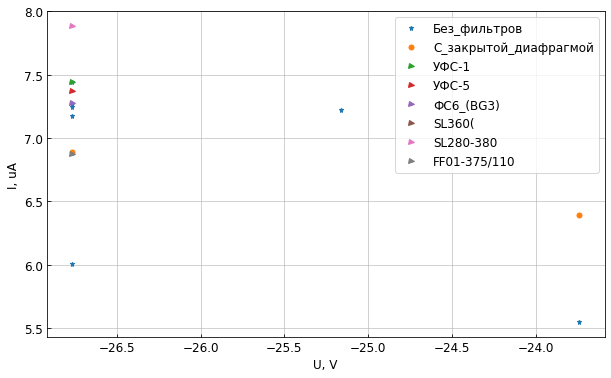

In [15]:
## график температур
draw_parameter('T')

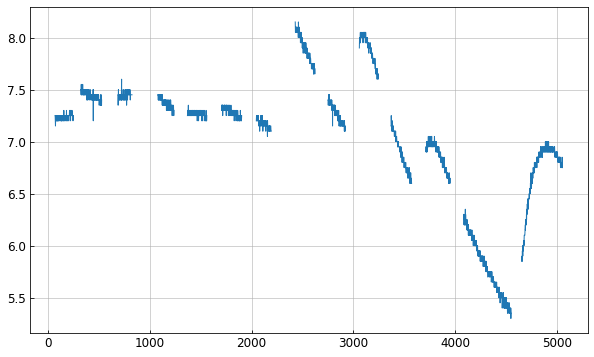

In [16]:
plt.plot(data['T'])
plt.grid()

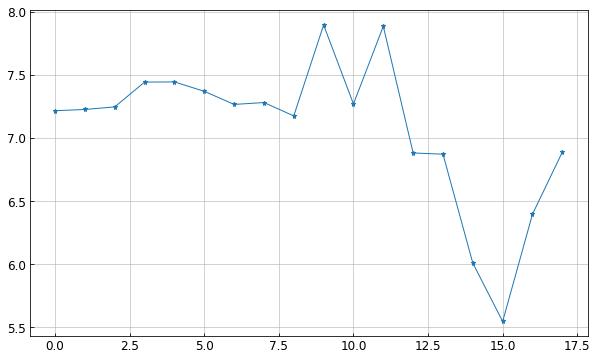

In [17]:
plt.plot(table['T'], '-*');
plt.grid()

## Учёт влияния температуры

### Вычитание теплового пьедестала

Определяем тепловой шум по измерениям с закрытой крышкой (серия номер 17).

Экспериментальные данные получены при напряжении питания ФЭУ -28.2В (ЦАП 250).
Кривая теплового шума f255() снята для напряжения -29.2В (ЦАП 255).

Приведем кривую к напряжению ЦАП 250, используя отношение токов при этих напряжениях: 35.2/41.2 = 0.8543689 (Взято из записей Димы, нужно проверить этот коэффициент).

Экспериментальная точка теплового шума при ЦАП 250 лежит на кривой f250(), поэтому коррекция термометра не нужна. иначе бы вводилась коррекция на температуру вида a * np.exp(0.079*(x - 1.85)). Т.е. отпределялась бы поправка - на сколько градусов нужно сдвинуть измеренное значение температуры, чтобы кривая теплового шума f250() прошла через экспериментальные значения. (Поправка на температуру составляла бы -1.85 градуса, если бы речь шла об измерениях при  коде 255).

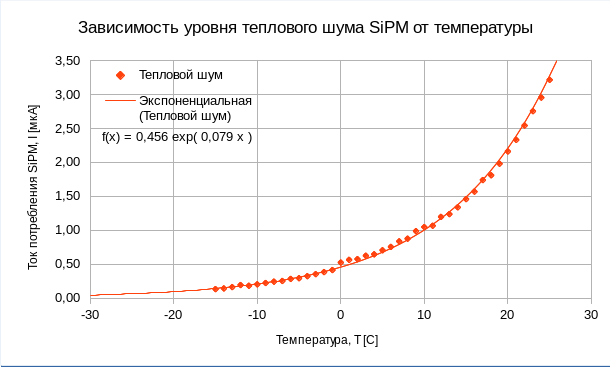

In [21]:
from IPython.display import Image 
Image("SiPM_AT.png", embed=True)

In [20]:
35.2/41.2

0.854368932038835

In [22]:
## тепловой шум для напряжения V = 29.2B, DAC = 255
def f255(x):
    return 0.456 * np.exp(0.079*(x))

## тепловой шум для напряжения V = 28.8B, DAC = 250
def f250(x):
    return f255(x) * 0.85436  ## 35.2/41.2 = 0.8543689

## тепловой шум для напряжения V = 29.2B, DAC = 255 с поправкой датчика температуры
def f(x):
    return 0.456 * np.exp(0.079*(x - 1.85))

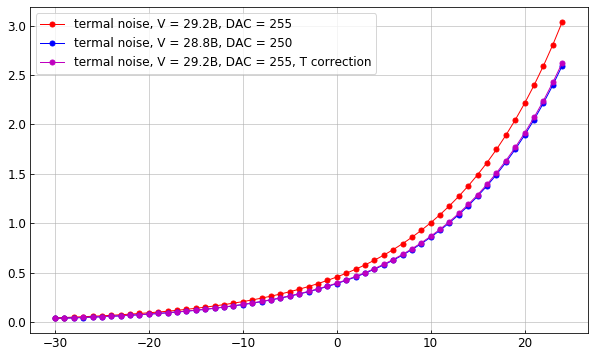

In [23]:
x = [x for x in range(-30,25,1)]
y = [f255(i) for i in x]
plt.plot(x,y,'r-o', label = "termal noise, V = 29.2B, DAC = 255")
y = [f250(i) for i in x]
plt.plot(x,y,'b-o', label = "termal noise, V = 28.8B, DAC = 250")
y = [f(i) for i in x]
plt.plot(x,y,'m-o', label = "termal noise, V = 29.2B, DAC = 255, T correction")

#plt.xlim(6, 8)
plt.legend()
plt.grid()

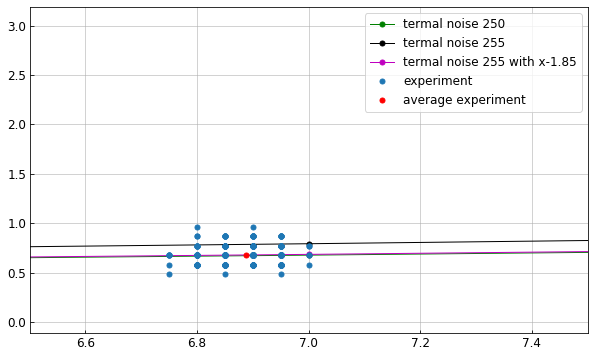

In [25]:
i = 17
part=data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
#print("{:.2f}  {:.2f}".format(j, f(j)) )

x = [x for x in range(-30,25,1)]
y = [f250(i) for i in x]
plt.plot(x,y,'g-o', label = "termal noise 250")

y = [f255(i) for i in x]
plt.plot(x,y,'k-o', label = "termal noise 255")

y = [f(i) for i in x]
plt.plot(x,y,'m-o', label = "termal noise 255 with x-1.85")

plt.plot(part['T'], part['I'], 'o', label = "experiment")
plt.plot(part['T'].mean(), part['I'].mean(), 'ro', label = "average experiment")
plt.xlim(6.5, 7.5)
plt.legend()
plt.grid()

### Вычитание теплового пьедестала.

    Берем тепловой шум (токовый пьедестал) из формулы f250() для кода напряжения 250 и вычитаем его из измереннного значения тока.

In [26]:
data['In'] = data['I'] - f250(data['T'])

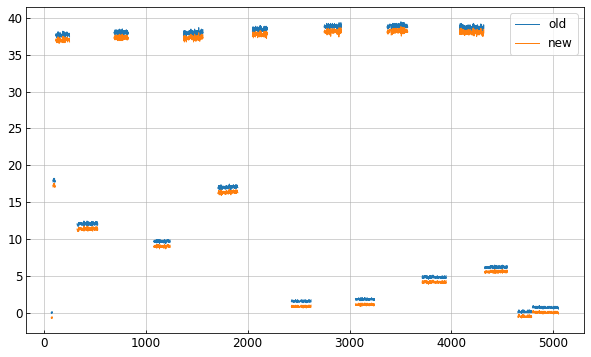

In [27]:
plt.plot(data['I'],  label = 'old')
plt.plot(data['In'], label = 'new')
plt.legend()
plt.grid()

## Засветка без фильтров

In [28]:
from matplotlib import dates
import datetime as dt

#matplotlib.style.use('ggplot')

In [29]:
nofilter = pd.DataFrame()
time_mean = []
cur_mean = []

## выделим данные при w 250 и без фильтров
for i in range(table.shape[0]-3):
    
    part = data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
    ## count mean time
    n = table.loc[i, 'count']
    table.loc[i,'In'] = part.In.mean()
    table.loc[i,'tmean'] = part.time.loc[part.time.index[0]+n//2]
    
    if (table.name[i] != 'Без_фильтров') or (table.w[i] != 250):        
        continue

    part['timestamp'] = part.date +' ' + part.time
    part['xtime']     = [dt.datetime.strptime(i, '%d.%m.%Y %H:%M:%S') for i in part.timestamp]
    print(i, n, part.shape, part.xtime.loc[part.xtime.index[0]+n//2] )
         
    nofilter = pd.concat([nofilter, part])
    cur_mean.append( part.In.mean())
    #time_mean.append(part.xtime.loc[part.xtime.index[0]+n//2] )
    time_mean.append(part.time.loc[part.time.index[0]+n//2] )

     
print(nofilter.shape)
nofilter.head()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 136 (136, 13) 2018-11-08 21:43:55
4 134 (134, 13) 2018-11-08 21:57:32
6 187 (187, 13) 2018-11-08 22:09:16
8 144 (144, 13) 2018-11-08 22:19:57
10 164 (164, 13) 2018-11-08 22:31:43
12 199 (199, 13) 2018-11-08 22:42:08
14 232 (232, 13) 2018-11-08 22:54:12
(1196, 13)


,date,time,CH0,CH1,CH2,CH3,U,I,U5,T,In,timestamp,xtime
117,08.11.2018,21:42:44,664.0,3702.0,474.0,1145.0,-26.76408,37.794061,4.94,7.25,37.103268,08.11.2018 21:42:44,2018-11-08 21:42:44
118,08.11.2018,21:42:45,663.0,3703.0,474.0,1144.0,-26.77936,37.697648,4.94,7.20,37.009578,08.11.2018 21:42:45,2018-11-08 21:42:45
119,08.11.2018,21:42:46,664.0,3705.0,474.0,1144.0,-26.76408,37.504821,4.94,7.20,36.816751,08.11.2018 21:42:46,2018-11-08 21:42:46
120,08.11.2018,21:42:47,664.0,3705.0,474.0,1145.0,-26.76408,37.504821,4.94,7.25,36.814028,08.11.2018 21:42:47,2018-11-08 21:42:47
121,08.11.2018,21:42:48,663.0,3703.0,474.0,1145.0,-26.77936,37.697648,4.94,7.25,37.006855,08.11.2018 21:42:48,2018-11-08 21:42:48


In [30]:
cur_filter_mean = []
time_filter_mean = []
for i in range(table.shape[0]-1):

    if (table.name[i] != 'Без_фильтров') and (table.w[i] == 250):   
        cur = 0.5 * (table.In[i-1] + table.In[i+1])
        print(i,cur, table.In[i-1],table.I[i+1])
        cur_filter_mean.append(cur)
        time_filter_mean.append(table.tmean[i])

3 37.1578597174136 36.99787796084023 38.019265416074255
5 37.30655847385627 37.31784147398697 37.98688777477823
7 37.52672444734318 37.295275473725574 38.44485152333206
9 37.94901418473002 37.75817342096078 38.831680979748484
11 38.178209293622544 38.139854948499256 38.887553851013664
13 38.12498534462208 38.21656363874584 38.65970384456827


In [31]:
time_filter_mean

['21:52:12', '22:04:09', '22:14:46', '22:26:40', '22:36:54', '22:48:04']

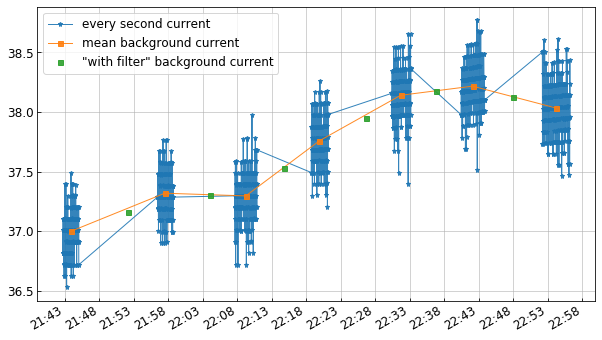

In [32]:
fig, ax = plt.subplots()

xx = [dt.datetime.strptime(i, '%H:%M:%S') for i in nofilter.time]
ax.plot(xx, nofilter.In, '-*', alpha=0.9, label = 'every second current')

xxx = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_mean]
ax.plot(xxx, cur_mean, '-s', alpha=0.9, label = 'mean background current')

xxf = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_filter_mean]
ax.plot(xxf, cur_filter_mean, 's', alpha=0.9, label = '\"with filter\" background current')


#ax.set_xticks(nofilter.timestamp)
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=5))  # <--- NOTE!
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.legend()
plt.grid()

4 689 827 21:56:27 21:58:45


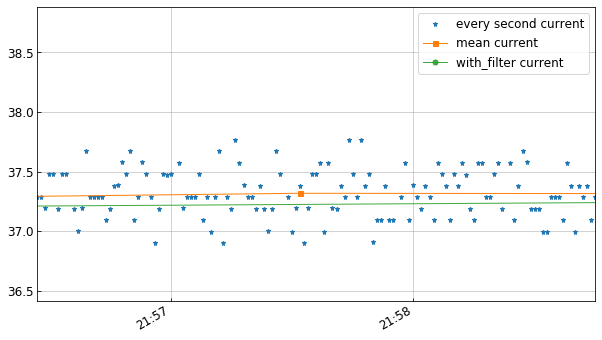

In [39]:
fig, ax = plt.subplots()

xx = [dt.datetime.strptime(i, '%H:%M:%S') for i in nofilter.time]
ax.plot(xx, nofilter.In, '*', label = 'every second current')

xxx = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_mean]
ax.plot(xxx, cur_mean, '-s',  label = 'mean current')

xxf = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_filter_mean]
ax.plot(xxf, cur_filter_mean, '-o', alpha=0.9, label = 'with_filter current')

ax.xaxis.set_major_locator(dates.MinuteLocator(interval=1))  # <--- NOTE!
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

#
i = 4
tmin = int(table.index0[i])
tmax = int(table.index1[i])
print(i, tmin, tmax, nofilter.time.loc[tmin], nofilter.time.loc[tmax],)
xmin = dt.datetime.strptime(nofilter.time.loc[tmin], '%H:%M:%S')
xmax = dt.datetime.strptime(nofilter.time.loc[tmax], '%H:%M:%S')

#tmin = 270  ##136
#tmax = 456  ##269
#xmin = dt.datetime.strptime(nofilter.time.loc[nofilter.time.index[tmin]], '%H:%M:%S')
#xmax = dt.datetime.strptime(nofilter.time.loc[nofilter.time.index[tmax]], '%H:%M:%S')
plt.xlim(xmin, xmax)
fig.autofmt_xdate()
plt.legend()
plt.grid()

In [97]:
nofilter.time.loc[nofilter.time.index[150]]

'21:56:42'

In [118]:
nofilter#.loc[126]

,date,time,CH0,CH1,CH2,CH3,U,I,U5,T,In,timestamp,xtime
117,08.11.2018,21:42:44,664.0,3702.0,474.0,1145.0,-26.76408,37.794061,4.94,7.25,37.103268,08.11.2018 21:42:44,2018-11-08 21:42:44
118,08.11.2018,21:42:45,663.0,3703.0,474.0,1144.0,-26.77936,37.697648,4.94,7.20,37.009578,08.11.2018 21:42:45,2018-11-08 21:42:45
119,08.11.2018,21:42:46,664.0,3705.0,474.0,1144.0,-26.76408,37.504821,4.94,7.20,36.816751,08.11.2018 21:42:46,2018-11-08 21:42:46
120,08.11.2018,21:42:47,664.0,3705.0,474.0,1145.0,-26.76408,37.504821,4.94,7.25,36.814028,08.11.2018 21:42:47,2018-11-08 21:42:47
121,08.11.2018,21:42:48,663.0,3703.0,474.0,1145.0,-26.77936,37.697648,4.94,7.25,37.006855,08.11.2018 21:42:48,2018-11-08 21:42:48
122,08.11.2018,21:42:49,664.0,3705.0,474.0,1144.0,-26.76408,37.504821,4.94,7.20,36.816751,08.11.2018 21:42:49,2018-11-08 21:42:49
123,08.11.2018,21:42:50,664.0,3705.0,474.0,1145.0,-26.76408,37.504821,4.94,7.25,36.814028,08.11.2018 21:42:50,2018-11-08 21:42:50
124,08.11.2018,21:42:51,664.0,3702.0,474.0,1145.0,-26.76408,37.794061,4.94,7.25,37.103268,08.11.2018 21:42:51,2018-11-08 21:42:51
125,08.11.2018,21:42:52,664.0,3703.0,474.0,1145.0,-26.76408,37.697648,4.94,7.25,37.006855,08.11.2018 21:42:52,2018-11-08 21:42:52
126,08.11.2018,21:42:53,664.0,3702.0,474.0,1145.0,-26.76408,37.794061,4.94,7.25,37.103268,08.11.2018 21:42:53,2018-11-08 21:42:53


703

In [149]:
data.head()

,date,time,CH0,CH1,CH2,CH3,U,I,U5,T,Tn,In
0,Input:,21:c+measurements_begin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Input:,18:c+without+filters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Input:,2:n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,08.11.2018,21:42:10,1439.0,4094.0,474.0,1145.0,-14.92208,0.0,4.94,7.25,5.4,-0.690793
73,08.11.2018,21:42:11,1440.0,4094.0,474.0,1145.0,-14.90680,0.0,4.94,7.25,5.4,-0.690793


In [ ]:
plt.plot(data['In'][name = ''], label = 'new')

In [ ]:
for i in range(table.shape[0]):
    print(i, f2, f(table['T'][i]), f2/ f(table['T'][i]),  sep='\t')
    table.loc[i, 'Inew'] = table.I[i] * f2/ f(table['T'][i])

In [37]:
table.drop(columns=['N','time'])

,name,w,begin,end,count,U,Ustd,I,Istd,T,Tstd,U5,U5std,index0,index1,In,tmean
0,Без_фильтров,0,21:42:10,21:42:22,13,-14.905625,0.011606,0.037082,0.062711,7.215385,0.031521,4.941538,0.003755,72.0,84.0,-0.651826,21:42:16
1,Без_фильтров,230,21:42:23,21:42:43,20,-25.164264,0.007184,17.942538,0.168161,7.225000,0.025649,4.941000,0.003078,91.0,110.0,17.253106,21:42:34
2,Без_фильтров,250,21:42:44,21:45:04,136,-26.767114,0.006394,37.688432,0.200830,7.245588,0.024699,4.940147,0.002103,117.0,252.0,36.997878,21:43:55
3,УФС-1,250,21:50:29,21:53:54,199,-26.766691,0.005967,12.055554,0.144973,7.441960,0.043353,4.942915,0.004556,326.0,529.0,11.354201,21:52:12
4,Без_фильтров,250,21:56:27,21:58:45,134,-26.766817,0.005881,38.019265,0.201319,7.443284,0.030529,4.941119,0.003609,689.0,827.0,37.317841,21:57:32
5,УФС-5,250,22:02:53,22:05:35,157,-26.766221,0.005321,9.686785,0.128502,7.369108,0.050171,4.942739,0.004474,1078.0,1239.0,8.989456,22:04:09
6,Без_фильтров,250,22:07:40,22:10:53,187,-26.767103,0.006104,37.986888,0.216050,7.264973,0.028215,4.940856,0.003165,1371.0,1561.0,37.295275,22:09:16
7,ФС6_(BG3),250,22:13:13,22:16:29,190,-26.766573,0.005661,17.035744,0.150788,7.280000,0.040434,4.940526,0.002464,1708.0,1903.0,16.343308,22:14:46
8,Без_фильтров,250,22:18:45,22:21:14,144,-26.765990,0.005383,38.444852,0.217986,7.174306,0.041386,4.941944,0.003972,2047.0,2193.0,37.758173,22:19:57
9,SL360\50,250,22:25:08,22:28:23,189,-26.766748,0.005816,1.548736,0.091476,7.894444,0.129989,4.944233,0.004954,2429.0,2622.0,0.821825,22:26:40


In [ ]:
table.to_csv("results.csv")